# Demo: Soft Actor Critic (SAC) Algorithm

References:
- [Open AI's Spinning Up: Soft Actor-Critic](https://spinningup.openai.com/en/latest/algorithms/sac.html)
- ["Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor" -- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, Sergey Levine](https://arxiv.org/abs/1801.01290)
- [rail-berkeley/softlearning](https://github.com/rail-berkeley/softlearning)

## Implementation of Algorithm

In [1]:
# install relevant packages, if necessary
# !pip install torch gymnasium gymnasium[mujoco]
# !pip install "gymnasium[other]"
# ! pip install matplotlib

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import os
from datetime import datetime, timedelta
import time

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

Transition = namedtuple('Transition',
                       ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))
        state = torch.FloatTensor(np.array(batch.state))
        action = torch.FloatTensor(np.array(batch.action))
        reward = torch.FloatTensor(np.array(batch.reward).reshape(-1, 1))
        next_state = torch.FloatTensor(np.array(batch.next_state))
        done = torch.FloatTensor(np.array(batch.done).reshape(-1, 1))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(GaussianPolicy, self).__init__()
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, action_dim)
        self.log_std_linear = nn.Linear(hidden_dim, action_dim)

        self.min_log_std = -20
        self.max_log_std = 2

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))

        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.min_log_std, self.max_log_std)

        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = torch.randn_like(mean)

        # Reparameterization trick
        sample = mean + std * normal

        # Compute log probability
        log_prob = (-0.5 * ((sample - mean) / std).pow(2) - log_std).sum(1, keepdim=True)

        # Apply tanh squashing
        action = torch.tanh(sample)
        log_prob = log_prob - torch.log(1 - action.pow(2) + 1e-6).sum(1, keepdim=True)

        return action, log_prob

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(QNetwork, self).__init__()
        self.linear1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class SAC:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dim = 256,
        buffer_size = 1_000_000,
        batch_size = 256,
        alpha = 0.2,
        gamma = 0.99,
        tau = 0.005,
        lr = 3e-4,
    ):
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha

        self.policy = GaussianPolicy(state_dim, action_dim, hidden_dim)
        self.q1 = QNetwork(state_dim, action_dim, hidden_dim)
        self.q2 = QNetwork(state_dim, action_dim, hidden_dim)
        self.q1_target = QNetwork(state_dim, action_dim, hidden_dim)
        self.q2_target = QNetwork(state_dim, action_dim, hidden_dim)

        # Copy parameters to target networks
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=lr)

        self.replay_buffer = ReplayBuffer(buffer_size)

        # For logging
        self.q_losses = []
        self.policy_losses = []
        self.mean_q_values = []

    def select_action(self, state, evaluate= False):
        state = torch.FloatTensor(state).unsqueeze(0)
        if evaluate:
            mean, _ = self.policy(state)
            return torch.tanh(mean).detach().numpy()[0]
        else:
            action, _ = self.policy.sample(state)
            return action.detach().numpy()[0]

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return 0, 0, 0

        state_batch, action_batch, reward_batch, next_state_batch, done_batch = \
            self.replay_buffer.sample(self.batch_size)

        # Update Q-functions
        with torch.no_grad():
            next_action, next_log_prob = self.policy.sample(next_state_batch)
            q1_next_target = self.q1_target(next_state_batch, next_action)
            q2_next_target = self.q2_target(next_state_batch, next_action)
            min_q_next_target = torch.min(q1_next_target, q2_next_target)
            next_q_value = reward_batch + (1 - done_batch) * self.gamma * \
                          (min_q_next_target - self.alpha * next_log_prob)

        q1_value = self.q1(state_batch, action_batch)
        q2_value = self.q2(state_batch, action_batch)
        q1_loss = F.mse_loss(q1_value, next_q_value)
        q2_loss = F.mse_loss(q2_value, next_q_value)

        # Update critic networks
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()

        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()

        # Update policy network
        action_new, log_prob = self.policy.sample(state_batch)
        q1_new = self.q1(state_batch, action_new)
        q2_new = self.q2(state_batch, action_new)
        min_q_new = torch.min(q1_new, q2_new)

        policy_loss = (self.alpha * log_prob - min_q_new).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # Update target networks
        for param, target_param in zip(self.q1.parameters(), self.q1_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.q2.parameters(), self.q2_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # Log metrics
        self.q_losses.append((q1_loss.item() + q2_loss.item()) / 2)
        self.policy_losses.append(policy_loss.item())
        self.mean_q_values.append(min_q_new.mean().item())

        return q1_loss.item(), q2_loss.item(), policy_loss.item()

## Train SAC Agent

In [4]:
def train_sac(
    env_name,
    max_episodes = 1000,
    max_steps = 1000,
    batch_size = 256,
):
    """Train SAC agent and return training metrics."""
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = SAC(state_dim, action_dim, batch_size=batch_size)
    episode_rewards = []

    t0 = time.perf_counter()
    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, done)

            if len(agent.replay_buffer) > batch_size:
                agent.update()

            state = next_state
            episode_reward += reward

            if done:
                break

        episode_rewards.append(episode_reward)

        if (episode + 1) % 10 == 0:
            t1 = time.perf_counter()
            elapsed = timedelta(seconds=t1 - t0)
            eta = (max_episodes - episode) * elapsed / episode
            print(f"Episode [{episode + 1} / {max_episodes}] | Reward: {episode_reward:.2f} | Elapsed Time: {elapsed} | ETA: {eta}")


    metrics = {
        'rewards': episode_rewards,
        'q_losses': agent.q_losses,
        'policy_losses': agent.policy_losses,
        'mean_q_values': agent.mean_q_values
    }

    return agent, metrics

In [5]:
def plot_metrics(metrics: dict) -> None:
    """Plot training metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics')

    # Plot rewards
    axes[0, 0].plot(metrics['rewards'])
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')

    # Plot Q losses
    axes[0, 1].plot(metrics['q_losses'])
    axes[0, 1].set_title('Q-Function Loss')
    axes[0, 1].set_xlabel('Update Step')
    axes[0, 1].set_ylabel('Loss')

    # Plot policy losses
    axes[1, 0].plot(metrics['policy_losses'])
    axes[1, 0].set_title('Policy Loss')
    axes[1, 0].set_xlabel('Update Step')
    axes[1, 0].set_ylabel('Loss')

    # Plot mean Q-values
    axes[1, 1].plot(metrics['mean_q_values'])
    axes[1, 1].set_title('Mean Q-Values')
    axes[1, 1].set_xlabel('Update Step')
    axes[1, 1].set_ylabel('Q-Value')

    plt.tight_layout()
    plt.show()

In [6]:
# Train the agent

# try increasing the number of training episodes, changing the environment, etc.
environment = "HalfCheetah-v5"
agent, rewards = train_sac(environment, max_episodes=250)

Episode [10 / 250] | Reward: -56.73 | Elapsed Time: 0:01:34.900392 | ETA: 0:42:21.221608
Episode [20 / 250] | Reward: -2.19 | Elapsed Time: 0:03:10.446596 | ETA: 0:38:35.429667
Episode [30 / 250] | Reward: 121.55 | Elapsed Time: 0:04:46.396709 | ETA: 0:36:22.540438
Episode [40 / 250] | Reward: 98.57 | Elapsed Time: 0:06:23.000696 | ETA: 0:34:32.131971
Episode [50 / 250] | Reward: 150.04 | Elapsed Time: 0:07:59.751836 | ETA: 0:32:47.961613
Episode [60 / 250] | Reward: 188.90 | Elapsed Time: 0:09:37.644292 | ETA: 0:31:10.001013
Episode [70 / 250] | Reward: 290.76 | Elapsed Time: 0:11:14.964686 | ETA: 0:29:30.559539
Episode [80 / 250] | Reward: 160.63 | Elapsed Time: 0:12:52.270523 | ETA: 0:27:51.623537
Episode [90 / 250] | Reward: 421.60 | Elapsed Time: 0:14:28.343571 | ETA: 0:26:10.823763
Episode [100 / 250] | Reward: 588.48 | Elapsed Time: 0:16:05.323464 | ETA: 0:24:32.362051
Episode [110 / 250] | Reward: 771.86 | Elapsed Time: 0:17:42.751026 | ETA: 0:22:54.751327
Episode [120 / 250] |

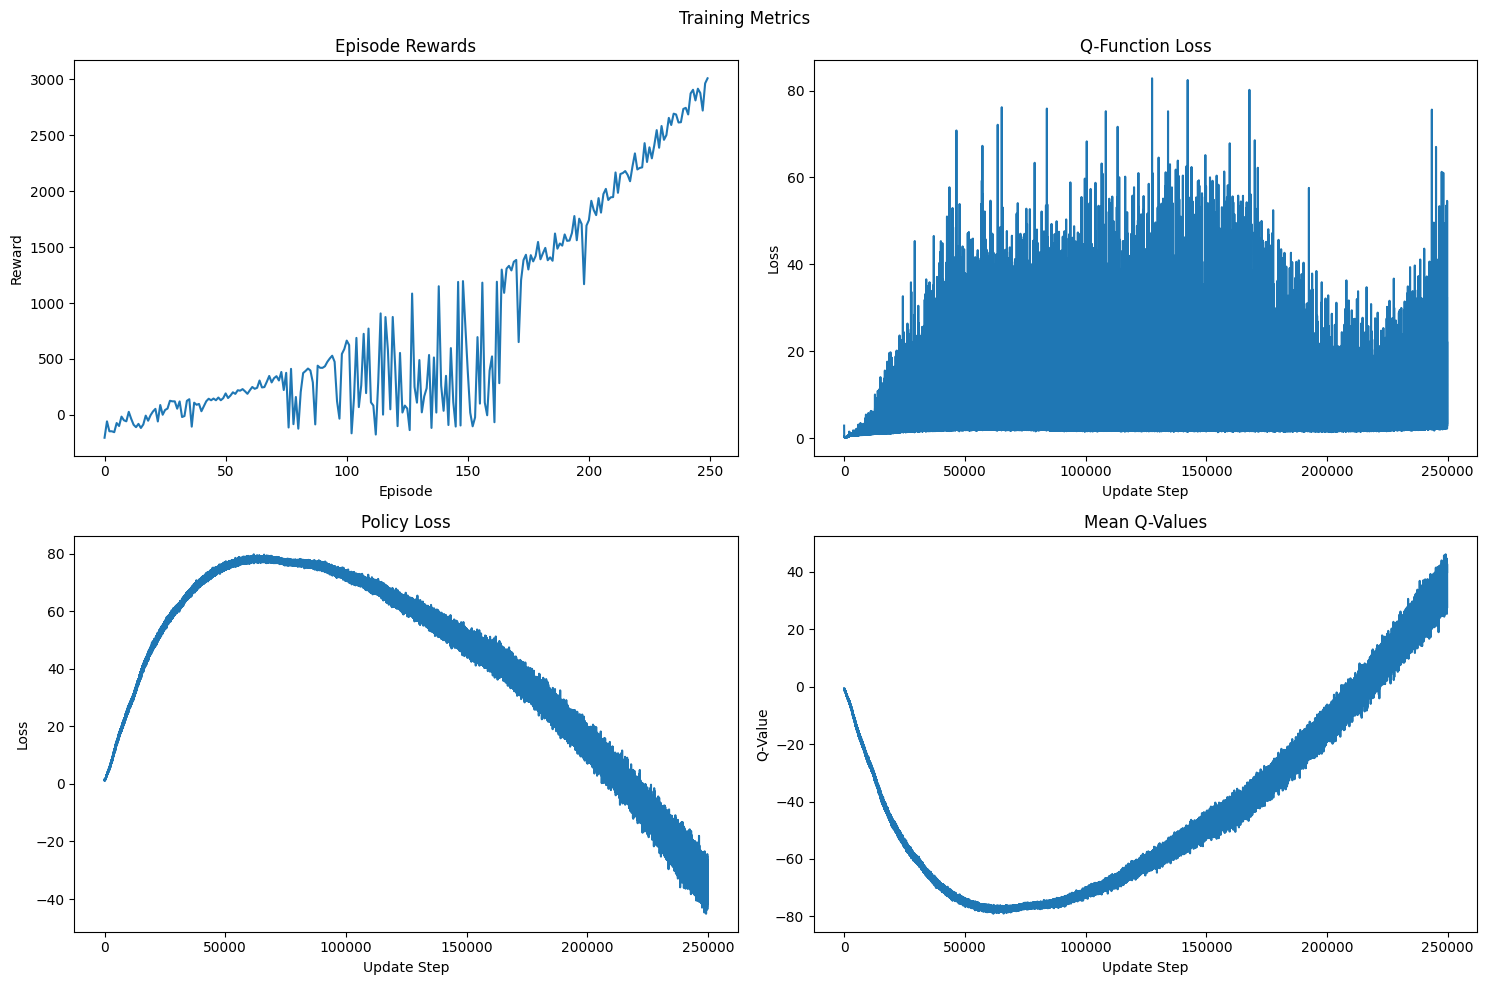

In [7]:
plot_metrics(rewards)

## Demo Trained Agent

In [8]:
def record_video(
    agent,
    environment,
    video_length = 250
):
    """
    Record a video of the trained agent.

    Args:
        agent (DDPG): Trained DDPG agent
        environment (str): Name of the Gymnasium environment to use
        video_length (int): Maximum length of the recording
    """

    env = gym.make(environment, render_mode='rgb_array')
    env = RecordVideo(env, video_folder='videos',
        episode_trigger=lambda x: True,
        name_prefix=f"sac_trained_agent_demo")

    state, _ = env.reset()
    total_reward = 0

    for _ in range(video_length):
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    env.close()
    print(f"Video recording completed with total reward: {total_reward:.2f}")

In [9]:
record_video(agent, environment)

/home/ma2393/.conda/envs/rl_course/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /gpfs/gibbs/project/lafferty/ma2393/RL_course/rl_algorithm_implementations/SAC/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video recording completed with total reward: 645.22


In [10]:
from IPython.display import Video
Video('videos/sac_trained_agent_demo-episode-0.mp4', embed=True)